In [13]:
import os
from pathlib import Path
import requests
import datetime
import json
import pandas as pd
import numpy as np
%matplotlib inline

from alpha_vantage.timeseries import TimeSeries


In [14]:
from numpy.random import seed
seed(23)
from tensorflow import random

random.set_seed(32)

In [15]:
ts = TimeSeries(key='alpha_vantage_api')

# Get json object with the daily price data and another with  the call's metadata


#SPDR S&P 500 ETF 
sp500_etf_data, sp500_etf_meta_data = ts.get_daily('SPY', outputsize='full')
sp500_etf_data['2020-06-30']

{'1. open': '303.9900',
 '2. high': '310.2000',
 '3. low': '303.8200',
 '4. close': '308.3600',
 '5. volume': '95892044'}

In [16]:
df = []
for x in sp500_etf_data:
        date = x
        close = sp500_etf_data[x]['4. close']
        df.append({
            "Date": date,
            "Close": close,
        })
tickers_df = pd.DataFrame(df)
tickers_df = tickers_df[['Date', 'Close']]
#tickers_df.sort_values(by='Date', ascending = False, inplace=True)
tickers_df['Date']= pd.to_datetime(tickers_df['Date'])
tickers_df.set_index("Date", inplace=True)
tickers_df.head()

,Close
Date,
2020-07-01,310.4100
2020-06-30,308.3600
2020-06-29,304.4600
2020-06-26,300.0500
2020-06-25,307.3500


In [17]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

### 2. Creating the features (X) and target (y) data using the window_data() function

In [19]:
window_size = 60
feature_column = 0
target_column = 0

X, y = window_data(tickers_df, window_size, feature_column, target_column)
# print (f"X sample values:\n{X[:5]} \n")
# print (f"y sample values:\n{y[:5]}")

### 3. Splitting Data Into Training and Testing

In [20]:
# Splitting 80% of the data for training and the remainder for testing.
split = int(0.80 * len(X))
X_train = X[: split - 1]
X_test = X[split:]
y_train = y[: split - 1]
y_test = y[split:]

### 4. Scale Data

In [21]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### 5. Reshape Data

In [22]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
#print (f"X_train sample values:\n{X_train[:5]} \n")
#print (f"X_test sample values:\n{X_test[:5]}")

### 6. Build and Train Model

In [23]:
# Importing required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [35]:
# a. Define the LSTM RNN model.
model = Sequential()

 # Initial model setup
number_units = 60
dropout_fraction = 0.4

 # Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))

 # Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))

 # Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))

 # Output layer
model.add(Dense(1))

In [36]:
# b. Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [37]:
# c. Summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 60, 60)            14880     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 60, 60)            29040     
_________________________________________________________________
dropout_4 (Dropout)          (None, 60, 60)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dropout_5 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                

In [38]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Train on 3976 samples
Epoch 1/10
3976/3976 [==============================] - 34s 9ms/sample - loss: 0.0047
Epoch 2/10
3976/3976 [==============================] - 30s 8ms/sample - loss: 0.0020
Epoch 3/10
3976/3976 [==============================] - 30s 8ms/sample - loss: 0.0020
Epoch 4/10
3976/3976 [==============================] - 31s 8ms/sample - loss: 0.0022
Epoch 5/10
3976/3976 [==============================] - 31s 8ms/sample - loss: 0.0021
Epoch 6/10
3976/3976 [==============================] - 31s 8ms/sample - loss: 0.0020
Epoch 7/10
3976/3976 [==============================] - 30s 8ms/sample - loss: 0.0019
Epoch 8/10
3976/3976 [==============================] - 32s 8ms/sample - loss: 0.0019
Epoch 9/10
3976/3976 [==============================] - 31s 8ms/sample - loss: 0.0020
Epoch 10/10
3976/3976 [==============================] - 33s 8ms/sample - loss: 0.0022


### 7. Make Predictions

In [39]:
# a. Make predictions using the testing data X_test
predicted = model.predict(X_test)

In [40]:
# b. Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Actual": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
})

# Show the DataFrame's head
stocks.head()

,Actual,Predicted
0,113.63,113.626656
1,113.83,113.626640
2,114.00,113.626656
3,114.02,113.626663
4,113.22,113.626663


### 8. Evaluate Model Performance

In [41]:
# Evaluate the model
model.evaluate(X_test, y_test, verbose=0)

0.004199759447689744

### 9. Plot

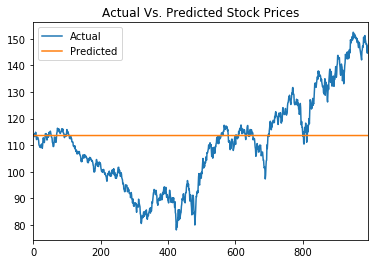

In [42]:
# Plot the real vs predicted prices as a line chart
stocks.plot(title="Actual Vs. Predicted Stock Prices")